## Book Recommendation system using K Nearest Neighbor

Dataset url: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

#### Read the dataset with the necessary features

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
books = pd.read_csv('book crossing dataset/Books.csv', sep=';',  encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher']
users = pd.read_csv('book crossing dataset/Users.csv', sep=';',  encoding="latin-1")
users.columns = ['userID', 'Age']
ratings = pd.read_csv('book crossing dataset/Ratings.csv', sep=';',  encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

C:\Users\muham\AppData\Local\Temp\ipykernel_12712\771554838.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv('book crossing dataset/Users.csv', sep=';',  encoding="latin-1")


In [5]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


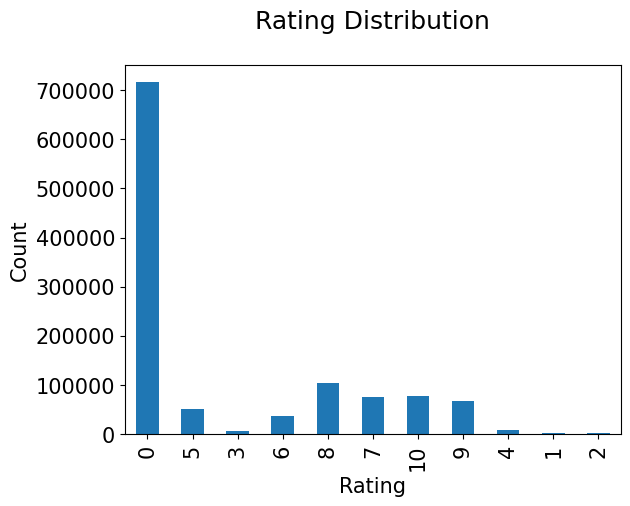

In [6]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

In [7]:
print(books.shape)
print(list(books.columns))

(271379, 5)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher']


In [8]:
print(users.shape)
print(list(users.columns))

(278859, 2)
['userID', 'Age']


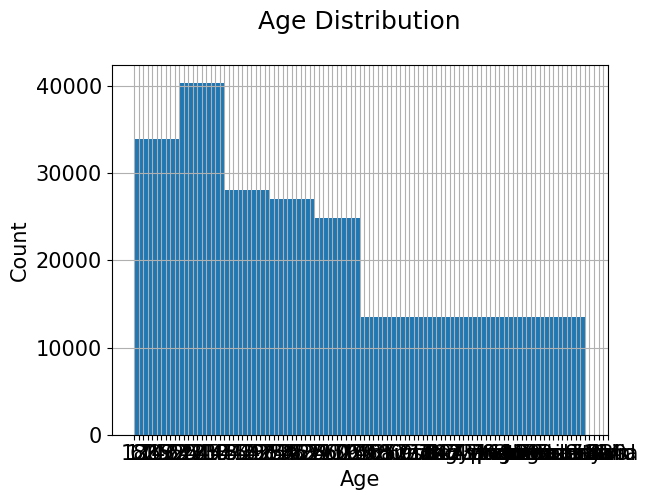

In [9]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

## To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.

In [10]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

## Collaborative Filtering Using k-Nearest Neighbors (kNN)

kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors. For example, we first present ratings in a matrix with the matrix having one row for each item (book) and one column for each user,

In [12]:
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,277427,0026217457,0,Vegetarian Times Complete Cookbook
2,277427,003008685X,8,Pioneers
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)"
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels)


We then group by book titles and create a new column for total rating count.

In [13]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


We combine the rating data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books.

In [14]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,7
2,277427,003008685X,8,Pioneers,1
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",1
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),13


In [15]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   160587.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: totalRatingCount, dtype: float64


The median book has been rated only once. Let’s look at the top of the distribution

In [16]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    5.000
0.910    6.000
0.920    7.000
0.930    7.000
0.940    8.000
0.950   10.000
0.960   11.000
0.970   14.000
0.980   19.000
0.990   31.000
Name: totalRatingCount, dtype: float64


In [17]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
13,277427,0060930535,0,The Poisonwood Bible: A Novel,133
15,277427,0060934417,0,Bel Canto: A Novel,108
18,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,108
24,277427,006440188X,0,The Secret Garden,79


In [18]:
rating_popular_book.shape

(62149, 5)

## Filter to users in US and Canada only

In [20]:
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')

# us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
# us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating=combined.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,277427,0060930535,0,The Poisonwood Bible: A Novel,133
2,277427,0060934417,0,Bel Canto: A Novel,108
3,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,108
4,277427,006440188X,0,The Secret Garden,79


## Cosine Similarity

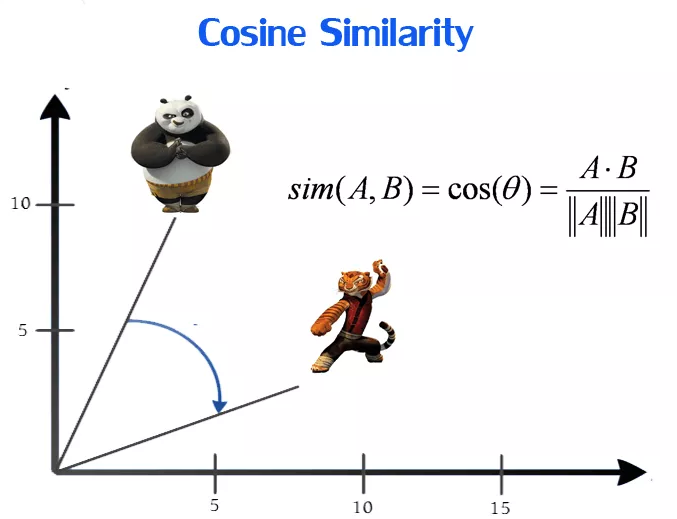

## Implementing kNN
We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

Finding the Nearest Neighbors
We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.

In [21]:
from scipy.sparse import csr_matrix
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [25]:
us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1,-1)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [22]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)



79


In [23]:
us_canada_user_rating_pivot.index[query_index]

'Birthright'

In [24]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Birthright:

1: Key of Knowledge (Key Trilogy (Paperback)), with distance of 0.4916119117042871:
2: Midnight Bayou, with distance of 0.532019657257282:
3: Dangerous, with distance of 0.5521382910652436:
4: Temptation, with distance of 0.5538851645174334:
5: The Reef, with distance of 0.564158340660476:
